In [43]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [44]:
# == Global variables ==

# theta_init, tau_1, tau_2 = paras
# np.pi/2, 1.653, 0.999

Paras_global = np.zeros(3)
Phi_global = None

Tau, Gamma_ps, Gamma_Dephase = 0, 0, 0

# == Relation between kraus_gamma vs tau
def Dephase_factor(tau):
    global Gamma_Dephase
    
    Cal_dephase = 1 - np.exp(-2 * tau)
    Gamma_Dephase = Cal_dephase
    
def Dephase_factor_Get_tau(gamma):
    global Tau 
    
    Cal_tau = -np.log( np.sqrt(1 - gamma))
    Tau = Cal_tau

$$
\rho_{After_Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}

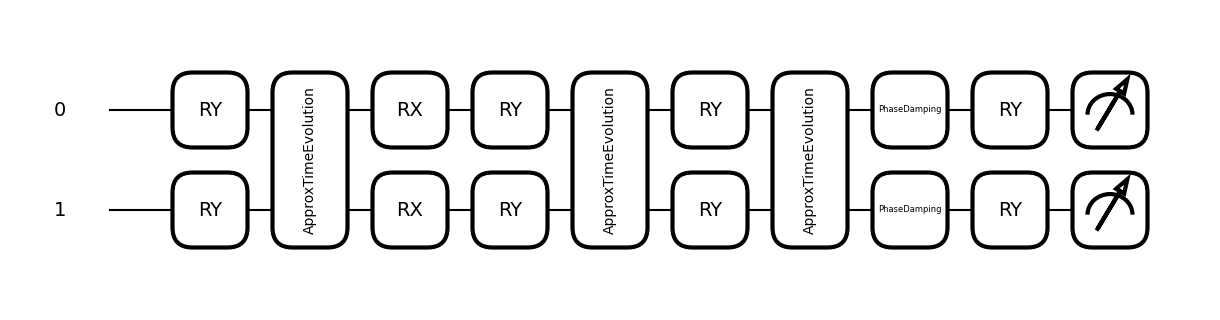

In [45]:
# == Generate circuit for dephase ==

@qml.qnode(dev)
def circuit_dephase(phi):
    theta_init, tau_1, tau_2 = Paras_global[0], Paras_global[1], Paras_global[2]
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    
    # Stage_4: Dephase by gamma
    qml.PhaseDamping(Gamma_Dephase, wires = 0)
    qml.PhaseDamping(Gamma_Dephase, wires = 1)
    
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit_dephase)(0)

In [46]:
# == Post-Selection with kraus operator ==

# set gamma_ps 
Gamma_ps = 0
Optimized_paras = 1.571, 1.653, 0.999

@qml.qnode(dev)
def Post_selection_Dephase(phi):
    
    global Paras_global
    Paras_global = Optimized_paras
    
    # Get density matrix from circuit_2
    density_matrix = circuit_dephase(phi)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])
    # return qml.probs(wires=[0, 1])

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  
,       

\rho_{ps} = 
\frac{(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})}

{Tr[(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})]}

In [47]:
def Plot_dephase(Plot_range, Step_size, Gamma_ps_select, tau):
    
    # Searching Range
    Sweep_Range = np.arange(Plot_range[0], Plot_range[1], Step_size)
    
    Num_CFI = len(tau)
    CFI = np_.zeros((Num_CFI, len(Sweep_Range)))
    
    for i in range(Num_CFI):
        for j in range(len(Sweep_Range)):
            
            # Set Dephase_gamma
            global Gamma_ps
            
            Gamma_ps = Gamma_ps_select
            Dephase_factor(tau[i])
            
            Temp = qml.qinfo.classical_fisher(Post_selection_Dephase)(Sweep_Range[j])
        
            # Casting to np.array
            CFI[i][j] = np.array(Temp[0], requires_grad = 'False')
        
            Temp = np.zeros(1)  
            
    for i in range(Num_CFI):
        plt.plot(Sweep_Range, CFI[i][:], label = f'tau = {tau[i]}')
    
    plt.title('CFI with Dephase at ' f'$\gamma$ = {Gamma_ps_select}')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid() 

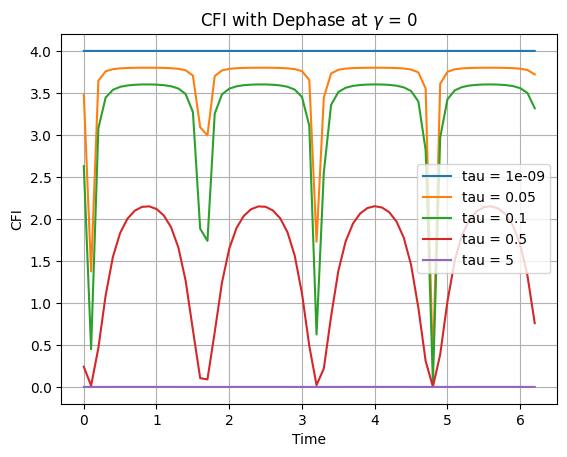

In [51]:
BOUND = np_.array([ 1e-3, np.pi * 2 + 1e-3])
Step_size_in = 0.1
# Step_size_in = 0.12566370614359174
Tau_in = 0.000000001, 0.05, 0.1, 0.5, 5
Gamma_in = 0, 0.8

Plot_dephase(BOUND, Step_size_in, Gamma_in[0], Tau_in)

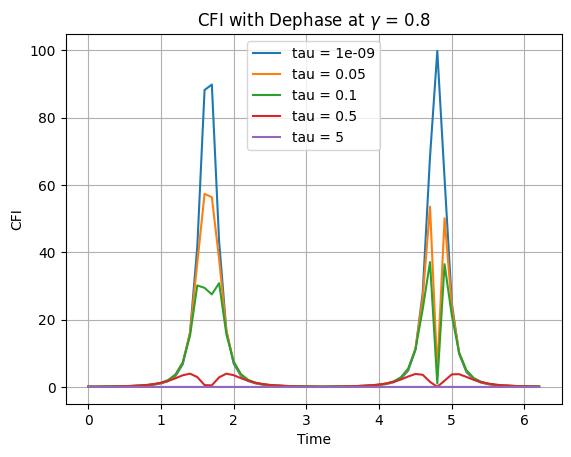

In [49]:
Plot_dephase(BOUND, Step_size_in, Gamma_in[1], Tau_in)